In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [2]:
data = 'C:/Users/Tejeswara Reddy/Downloads/brain_tumor_dataset/'
No_brain_tumor = 'C:/Users/Tejeswara Reddy/Downloads/brain_tumor_dataset/no/'
Yes_brain_tumor = 'C:/Users/Tejeswara Reddy/Downloads/brain_tumor_dataset/yes/'

In [3]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,C:/Users/Tejeswara Reddy/Downloads/brain_tumor...,No
1,C:/Users/Tejeswara Reddy/Downloads/brain_tumor...,No
2,C:/Users/Tejeswara Reddy/Downloads/brain_tumor...,No
3,C:/Users/Tejeswara Reddy/Downloads/brain_tumor...,No
4,C:/Users/Tejeswara Reddy/Downloads/brain_tumor...,No


In [5]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


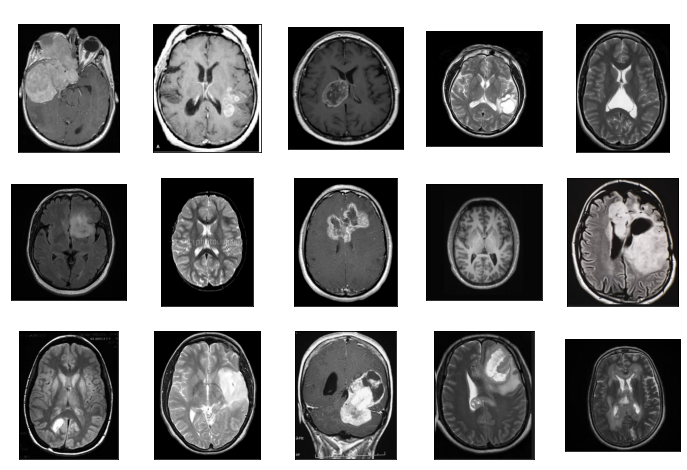

In [6]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [9]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [10]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [11]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet", 
    input_shape=(224, 224, 3),
    include_top=False,
)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [13]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, callbacks = [callbacks], verbose = 1)

Epoch 1/100
7/7 [==============================] - 13s 1s/step - loss: 0.5026 - accuracy: 0.7870 - val_loss: 0.4554 - val_accuracy: 0.8333
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 0.4819 - accuracy: 0.7824 - val_loss: 0.4711 - val_accuracy: 0.8750
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.4816 - accuracy: 0.7731 - val_loss: 0.5280 - val_accuracy: 0.6667
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 0.4894 - accuracy: 0.7593 - val_loss: 0.5218 - val_accuracy: 0.7500
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 0.4709 - accuracy: 0.8056 - val_loss: 0.4686 - val_accuracy: 0.8333
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 0.5153 - accuracy: 0.7361 - val_loss: 0.4524 - val_accuracy: 0.7500
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.4818 - accuracy: 0.7824 - val_loss: 0.4904 - val_accuracy: 0.7500
Epoch 8/100
7/7 [================

Epoch 60/100
7/7 [==============================] - 8s 1s/step - loss: 0.3777 - accuracy: 0.8102 - val_loss: 0.3461 - val_accuracy: 0.8333
Epoch 61/100
7/7 [==============================] - 7s 1s/step - loss: 0.3351 - accuracy: 0.8657 - val_loss: 0.3545 - val_accuracy: 0.9167
Epoch 62/100
7/7 [==============================] - 7s 1s/step - loss: 0.3287 - accuracy: 0.8657 - val_loss: 0.3890 - val_accuracy: 0.8750
Epoch 63/100
7/7 [==============================] - 7s 1s/step - loss: 0.3162 - accuracy: 0.8889 - val_loss: 0.3521 - val_accuracy: 0.8333
Epoch 64/100
7/7 [==============================] - 7s 1s/step - loss: 0.3328 - accuracy: 0.8565 - val_loss: 0.3537 - val_accuracy: 0.8333
Epoch 65/100
7/7 [==============================] - 9s 1s/step - loss: 0.3386 - accuracy: 0.8472 - val_loss: 0.3671 - val_accuracy: 0.8333
Epoch 66/100
7/7 [==============================] - 13s 1s/step - loss: 0.3407 - accuracy: 0.8519 - val_loss: 0.2960 - val_accuracy: 0.9167
Epoch 67/100
7/7 [========

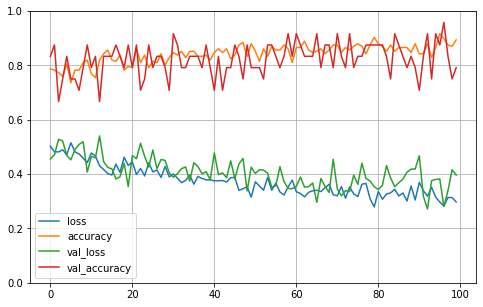

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [15]:
model.save("D:/brain tumer detection/Tumor_classifier_model.h5")

In [24]:
from PIL import Image
model_path = "Tumor_classifier_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("C:/Users/Tejeswara Reddy/Downloads/brain_tumor_dataset/no/10 no.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
    print('yes')
else:
    print('no')

1/1 [==============================] - 1s 1s/step
no
